<a href="https://colab.research.google.com/github/RezowanTalukder/BERT-Bangla-Intent-Classfication/blob/main/intent_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install bert-for-tf2

     |████████████████████████████████| 51kB 2.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30539 sha256=860b3c38f89634fbff19356bbd2845b4abb03e7681ff6c30495f189acf4cc17b
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=b9ee25ff1668bf1f9395fc42a21092b942a8bb283bd0b7cf78b3b13ac9b1c899
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=dd75656218557a95f2bf2da29180433180ae3f623a51ce135f96b2979315a8d3
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [2]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("success!")

success!


In [5]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [6]:
train.shape
valid.head()

,text,intent
0,প্রকৃতপক্ষে,affirm
1,সঠিক,affirm
2,ভাল লাগছে,affirm
3,হ্যাঁ plz,affirm
4,অবশ্যই,affirm


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


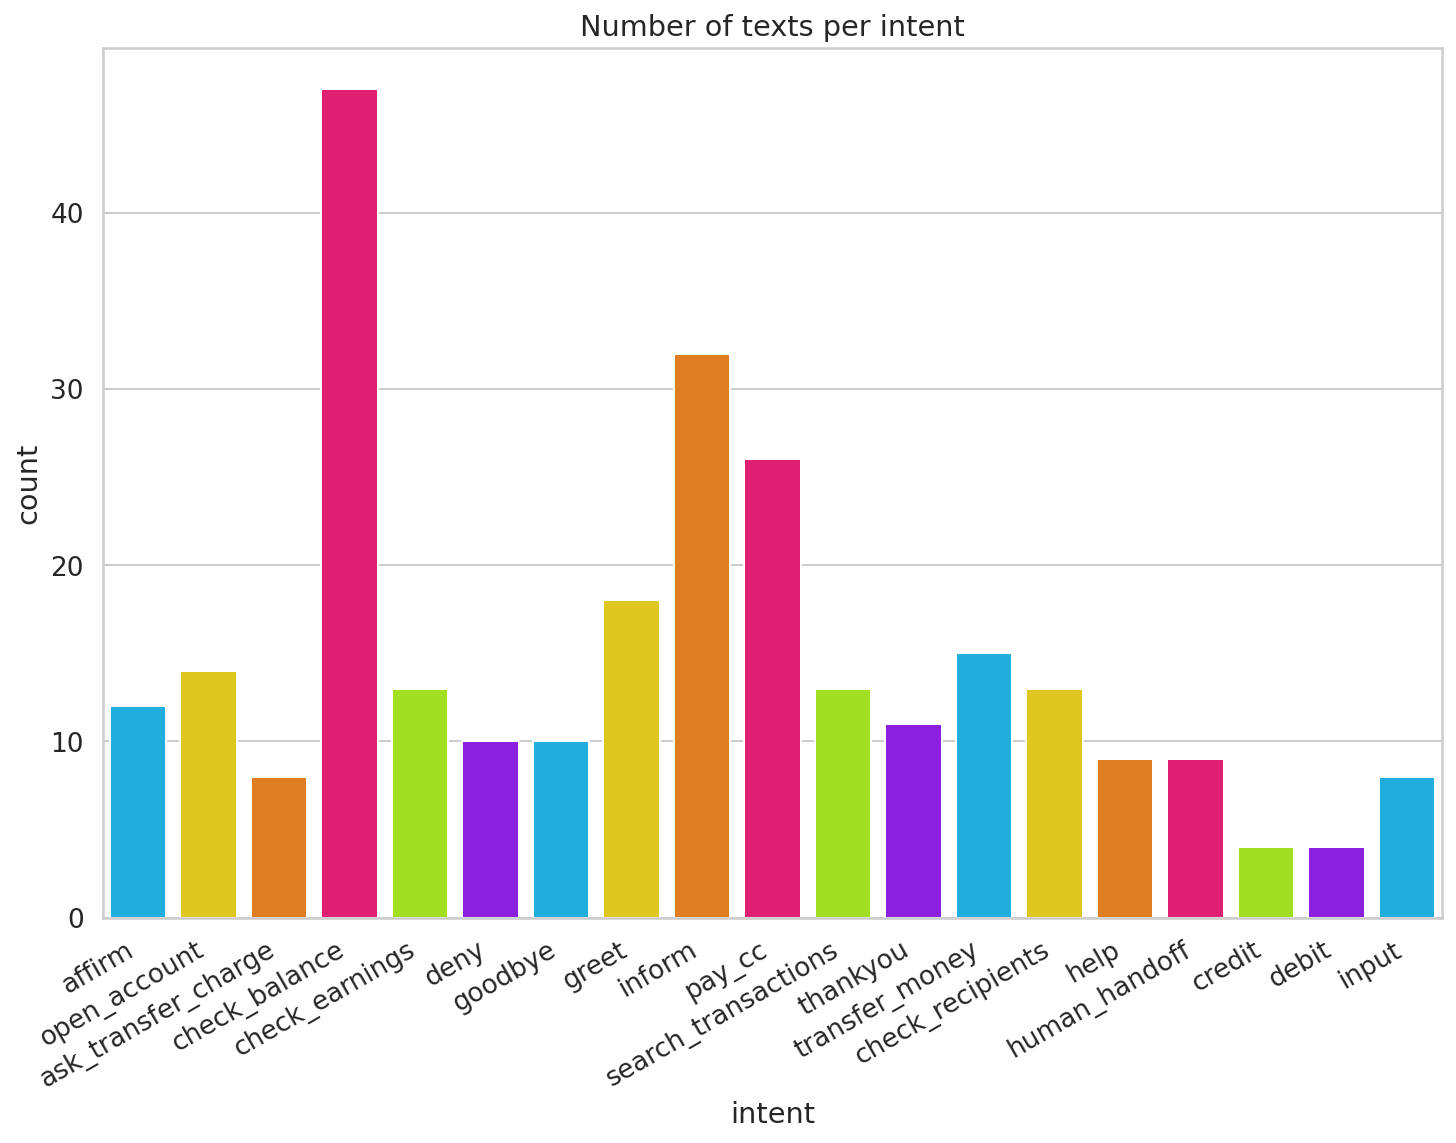

In [7]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [8]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-11-04 04:22:51--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M   111MB/s    in 5.7s    

2020-11-04 04:22:57 (111 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [9]:
!unzip multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [15]:
os.makedirs("model", exist_ok=True)

In [11]:
!mv multi_cased_L-12_H-768_A-12.zip/ model

mv: cannot stat 'multi_cased_L-12_H-768_A-12.zip/': Not a directory


In [17]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [35]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      print(tokens)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      print(tokens)
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [36]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"), do_lower_case=False)

In [48]:
tokens = tokenizer.tokenize("গত মাসে আমি কতটা ব্যয় করেছি?")
print(tokens)

['গত', 'মাসে', 'আমি', 'কতটা', 'ব্যয়', 'করেছি', '?']


In [37]:
tokenizer.convert_tokens_to_ids(tokens)

[90447,
 13542,
 110304,
 29993,
 65435,
 37376,
 100636,
 13542,
 36715,
 69952,
 15215,
 13228,
 101514,
 53574,
 12235,
 136]

In [38]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [39]:
classes = train.intent.unique().tolist()
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

276it [00:00, 1871.32it/s]
42it [00:00, 1623.05it/s]

['প্রকৃতপক্ষে']
['[CLS]', 'প্রকৃতপক্ষে', '[SEP]']
['সঠিক']
['[CLS]', 'সঠিক', '[SEP]']
['ভাল', 'লাগছে']
['[CLS]', 'ভাল', 'লাগছে', '[SEP]']
['হ্যাঁ']
['[CLS]', 'হ্যাঁ', '[SEP]']
['হ্যাঁ', 'দয়া', 'করে']
['[CLS]', 'হ্যাঁ', 'দয়া', 'করে', '[SEP]']
['অবশ্যই']
['[CLS]', 'অবশ্যই', '[SEP]']
['হা']
['[CLS]', 'হা', '[SEP]']
['হ্যাঁ', 'pl', '##z']
['[CLS]', 'হ্যাঁ', 'pl', '##z', '[SEP]']
['অবশ্যই']
['[CLS]', 'অবশ্যই', '[SEP]']
['ঠিক', 'আছে']
['[CLS]', 'ঠিক', 'আছে', '[SEP]']
['মিষ্টি']
['[CLS]', 'মিষ্টি', '[SEP]']
['শীতল']
['[CLS]', 'শীতল', '[SEP]']
['আমি', 'একাউন্ট', 'খুলতে', 'চাই']
['[CLS]', 'আমি', 'একাউন্ট', 'খুলতে', 'চাই', '[SEP]']
['আমি', 'একাউন্ট', 'খ', '##ুল', '##ব']
['[CLS]', 'আমি', 'একাউন্ট', 'খ', '##ুল', '##ব', '[SEP]']
['একাউন্ট', 'খুলতে', 'চাই']
['[CLS]', 'একাউন্ট', 'খুলতে', 'চাই', '[SEP]']
['আম', '##ো', 'অ্যাকাউন্ট', 'খুলুন', 'ক্রো', '##ব', '##ো']
['[CLS]', 'আম', '##ো', 'অ্যাকাউন্ট', 'খুলুন', 'ক্রো', '##ব', '##ো', '[SEP]']
['অ্যাকাউন্ট', 'খোলা', 'ক্রো', '##ব', '##ো']
['[CLS]', 'অ্যাকা

In [40]:
data.train_x.shape
data.train_x[0]
data.train_y[0]
data.max_seq_len

18

In [41]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 18, 768)
loader: Skipping weight:[bert/embeddings/word_embeddings/embeddings:0] as the weight shape:[(226645, 768)] is not compatible with the checkpoint:[bert/embeddings/word_embeddings] shape:(119547, 768)
Done loading 195 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7efdf437aa90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [1]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/embeddings/word_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [42]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 18)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 18, 768)           259512576 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)               

In [43]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [44]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
16/16 [==============================] - 86s 5s/step - loss: 2.9263 - acc: 0.0847 - val_loss: 2.9980 - val_acc: 0.0000e+00
Epoch 2/5
16/16 [==============================] - 77s 5s/step - loss: 2.8647 - acc: 0.1815 - val_loss: 3.0276 - val_acc: 0.0000e+00
Epoch 3/5
16/16 [==============================] - 77s 5s/step - loss: 2.8166 - acc: 0.2298 - val_loss: 3.0076 - val_acc: 0.0000e+00
Epoch 4/5
16/16 [==============================] - 77s 5s/step - loss: 2.7858 - acc: 0.2863 - val_loss: 3.0279 - val_acc: 0.0000e+00
Epoch 5/5
16/16 [==============================] - 77s 5s/step - loss: 2.7266 - acc: 0.3105 - val_loss: 3.0291 - val_acc: 0.0000e+00


In [45]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

2/2 [==============================] - 1s 349ms/step - loss: 2.6718 - acc: 0.3571
train acc 0.27898550033569336
test acc 0.3571428656578064


In [46]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [47]:
sentences = [
  "দয়া করে আমাকে একজনকে দিন",
  "আমি একটা অ্যাকাউন্ট খুলতে চাই ",
  "আমার ক্রেডিট কার্ডের ব্যালেন্স কি?"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: দয়া করে আমাকে একজনকে দিন 
intent: check_balance

text: আমি একটা অ্যাকাউন্ট খুলতে চাই  
intent: inform

text: আমার ক্রেডিট কার্ডের ব্যালেন্স কি? 
intent: check_balance

